In [158]:
import numpy as np
import scipy as sp
import scipy.constants as spc
from scipy.integrate import simps
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import os
from scipy.misc import imread

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline 
from pylab import *
from mpl_toolkits.mplot3d.axes3d import Axes3D

import time
from cs231n.classifiers.fc_net import *
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver
from cs231n.solver_waveprop import SolverWaveProp

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
## Specify Lens Characteristic
#apertureLength = 2.0e-3; # meters (Side length for square, Diameter for circle)
#focalLength = 1.0e-1; # meters
waveLength  = 1.0e-6; # meters

# For fersnelNumber, use 4.0 for main lobe to be a full pixel's width. 
# Use 8.0 for main lobe to be a half pixel's width. 
fersnelNumber = 4.0 #(apertureLength**2.0)/(focalLength*waveLength)
ratio2 = 1.0
#ratio = apertureLength/waveLength;

#ratio2 = focalLength/apertureLength

apertureToFocalPlaneFactor = 1.0
#focalPlaneLength = apertureToFocalPlaneFactor*apertureLength; #meters

#pixelSize      = 1e-3; # meters
numberOfPixels = 2 #int(math.ceil(focalPlaneLength/pixelSize));


dPixel      = apertureToFocalPlaneFactor/numberOfPixels
pixelPoints    = -apertureToFocalPlaneFactor/2.0 + dPixel*np.arange(0.0,numberOfPixels+1)


centerPoints = pixelPoints[0:len(pixelPoints)-1]+dPixel/2.0

# Simuation Parameters
segmentsPerPixel                 = 5
pointsPerPixel                   = segmentsPerPixel+1
numberOfSegmentsInFocalPlane     = segmentsPerPixel*numberOfPixels
dFocalPlane                      = apertureToFocalPlaneFactor/numberOfSegmentsInFocalPlane
focalPlanePoints                 = -apertureToFocalPlaneFactor/2.0 + dFocalPlane*np.arange(0.0,numberOfSegmentsInFocalPlane+1)
focalPlaneMeshX, focalPlaneMeshY = np.meshgrid(focalPlanePoints, focalPlanePoints)

#focalPlanePointsWithUnits = apertureLength*focalPlanePoints
#dFocalPlaneWithUnits      = apertureLength*dFocalPlane


# Physical Constants
#sp.constants.codata.unit('the electric constant')
vacuumPermittivity = spc.epsilon_0
speedOfLight       = spc.c
planksConstant     = spc.Planck 
returnIrradiance  = 1e-3 # (W/m^2)
#amplitudeOfLight   = 1.0; # Electric field amplitude
pulseDuration      = 50e-6; # seconds
joulesPerPhoton    = speedOfLight*planksConstant/waveLength



In [ ]:
numberOfPixels
print ratio2

In [161]:
def generateData(n,SNR=None, fersnelNumber=4):
    ## Simulation Parameters
    data = {}
    data['X'] = np.zeros((n,numberOfPixels,numberOfPixels))
    data['y'] = np.zeros((n,2))
    data['c'] = np.zeros((n,2))
    for i in xrange(n):
        #theta = np.random.normal()*np.pi # angle from Z axis (0-pi/2)
        #phi   = np.random.normal()*np.pi
        
        # Could also make y-values the xTilt and yTilt
        #xTilt = -.5*np.random.uniform(-1.0,1.0)#np.sin(theta)*np.cos(phi)
        #yTilt = -.5*np.random.uniform(-1.0,1.0)#np.sin(theta)*np.sin(phi)
        # Top right corner only
        xTilt = -.5*np.random.uniform(-1.0,1.0)
        yTilt = -.5*np.random.uniform(-1.0,1.0)
        data['y'][i,0] = -ratio2*xTilt
        data['y'][i,1] = -ratio2*yTilt
        pixelPointsXMesh, pixelPointsYMesh = np.meshgrid(pixelPoints,pixelPoints)
        scatterPixelPointsX = np.reshape(pixelPointsXMesh,(1,np.size(pixelPointsXMesh)))
        scatterPixelPointsY = np.reshape(pixelPointsYMesh,(1,np.size(pixelPointsYMesh)))
        Fx = np.sinc(fersnelNumber*(focalPlaneMeshX + ratio2*xTilt))
        #plt.plot(spaceDimensionPoints,Fx**2.0)
        Fy = np.sinc(fersnelNumber*(focalPlaneMeshY + ratio2*yTilt))
        #irradiance = vacuumPermittivity*speedOfLight*(amplitudeOfLight**2.0) * (Fx**2.0) * (Fy**2.0)
        irradiance = returnIrradiance * (Fx**2.0) * (Fy**2.0)
        pixelBlocks = np.zeros((numberOfPixels,numberOfPixels,pointsPerPixel,pointsPerPixel))

        meshXBlocks = np.zeros((numberOfPixels,numberOfPixels,pointsPerPixel,pointsPerPixel))
        meshYBlocks = np.zeros((numberOfPixels,numberOfPixels,pointsPerPixel,pointsPerPixel))
        integrals    = np.zeros([numberOfPixels,numberOfPixels])

        for indexPixel1 in range(0,numberOfPixels):
            for indexPixel2 in range(0,numberOfPixels):
                for indexPoint1 in range(0,pointsPerPixel):
                    for indexPoint2 in range(0,pointsPerPixel):
                        pixelBlocks[indexPixel1,indexPixel2,indexPoint1,indexPoint2] = irradiance[indexPixel1*(pointsPerPixel-1) + indexPoint1
                                                                                                ,indexPixel2*(pointsPerPixel-1) + indexPoint2]
                        meshXBlocks[indexPixel1,indexPixel2,indexPoint1,indexPoint2] = focalPlaneMeshX[indexPixel1*(pointsPerPixel-1) + indexPoint1
                                                                                                ,indexPixel2*(pointsPerPixel-1) + indexPoint2]
                        meshYBlocks[indexPixel1,indexPixel2,indexPoint1,indexPoint2] = focalPlaneMeshY[indexPixel1*(pointsPerPixel-1) + indexPoint1
                                                                                                ,indexPixel2*(pointsPerPixel-1) + indexPoint2]
         
                        x = meshXBlocks[indexPixel1,indexPixel2,0,:]
                        y = meshYBlocks[indexPixel1,indexPixel2,:,0]
        
                        integrals[indexPixel1,indexPixel2] = simps(simps(pixelBlocks[indexPixel1,indexPixel2,:,:], y), x)

        photonsOrElectrons = (integrals/joulesPerPhoton)*pulseDuration
        totalNumberOfSignalElectrons = np.sum(photonsOrElectrons)
        if SNR == None:
            sigmaElectrons = 0
        else:
            sigmaElectrons = np.sqrt( (1.0/numberOfPixels**2) * ( ((totalNumberOfSignalElectrons/SNR))**2 - totalNumberOfSignalElectrons) )
        photonsOrElectronsWithNoise = photonsOrElectrons + sigmaElectrons*np.random.randn(integrals.shape[0],integrals.shape[1])
        photonsOrElectronsWithNoise = np.maximum(photonsOrElectronsWithNoise,0)
        
        #integrals = np.fliplr(integrals.T).T
        #print "Data run %s done." %i 
        
        
        # Find centers of each cell and overall centroid
        centerX, centerY = np.meshgrid(centerPoints,centerPoints)
        #print centerX[1,3]
        #print centerY[1,3]
        
        
        # Gaussian data
        #mean = np.array([np.random.uniform(-.5,.5),np.random.uniform(-.5,.5)])
        #data['y'][i,0] = mean[0]
        #data['y'][i,1] = mean[1]
        #cov = np.array([[1, 0], [0, 1]])
        #A = 1 #1/(2*np.pi)
        #o=.125
        #for i2 in range(0,numberOfPixels):
        #    for j2 in range(0,numberOfPixels):
        #        integrals[i2,j2] = A*np.exp(-(centerX[i2,j2]-mean[0])**2/(2*o**2))*np.exp(-(centerY[i2,j2]-mean[1])**2/(2*o**2))
        #fig = plt.figure()
        #ax = fig.add_subplot(111)#, projection='3d')
        #ax.contour(centerX, centerY, integrals)
        
        data['X'][i,:] = photonsOrElectronsWithNoise
        centerX = np.reshape(centerX,(1,np.size(centerX)))
        centerY = np.reshape(centerY,(1,np.size(centerY)))
        
        photonsOrElectronsWithNoise = np.reshape(photonsOrElectronsWithNoise,(1,np.size(photonsOrElectronsWithNoise)))
        meanX = np.sum(centerX*photonsOrElectronsWithNoise)/np.sum(photonsOrElectronsWithNoise)
        meanY = np.sum(centerY*photonsOrElectronsWithNoise)/np.sum(photonsOrElectronsWithNoise)
        centroid = [meanX, meanY]
        #print centroid
        centers = np.hstack((centerX.T,centerY.T))
        data['c'][i,0] = meanX
        data['c'][i,1] = meanY

        #ax.scatter(data['c'][i,0],data['c'][i,1],color='red')
        #ax.scatter(data['y'][i,0],data['y'][i,1],color='blue')
        #ax.contourf(focalPlaneMeshX,focalPlaneMeshY, irradiance)
        #fig2 = plt.figure()
        #ax2 = fig2.add_subplot(111)#, projection='3d')
        #ax2.contourf(focalPlaneMeshX,focalPlaneMeshY, irradiance)
        
        # Graph for function
        #fig, ax = plt.subplots(figsize=(8,8))
        #p = ax.contourf(focalPlaneMeshX,focalPlaneMeshY,irradiance,100)
        #ax.scatter(scatterPixelPointsX, scatterPixelPointsY,color="red")
        #fig.colorbar(p)
    return data

In [162]:
def generateValidationData(n=50,SNR=None,fersnelNumber=4.0):
    ## Simulation Parameters
    data = {}
    data['X'] = np.zeros((n,numberOfPixels,numberOfPixels))
    data['y'] = np.zeros((n,2))
    data['c'] = np.zeros((n,2))
    #
    locs = np.linspace(-.5,.5,num=n)
    #
    #locs = np.linspace(-.5,.5,num=np.sqrt(n))
    #x,y = np.meshgrid(locs,locs)
    #x.reshape((1,x.shape[0]*x.shape[1]))
    #y.reshape((1,y.shape[0]*y.shape[1]))
    #
    #locsx = np.linspace(0,.375,num=n)
    #locsy = np.linspace(.125,.5,num=n)
    #
    #locsx = np.linspace(.125,.5,num=n)
    #locsy = np.linspace(.5,.125,num=n)
    for i in xrange(n):
        xTilt = -locs[i] # -x[0]
        yTilt = -locs[i] # -y[0]
        data['y'][i,0] = -ratio2*xTilt
        data['y'][i,1] = -ratio2*yTilt
        pixelPointsXMesh, pixelPointsYMesh = np.meshgrid(pixelPoints,pixelPoints)
        scatterPixelPointsX = np.reshape(pixelPointsXMesh,(1,np.size(pixelPointsXMesh)))
        scatterPixelPointsY = np.reshape(pixelPointsYMesh,(1,np.size(pixelPointsYMesh)))
        Fx = np.sinc(fersnelNumber*(focalPlaneMeshX + ratio2*xTilt))
        Fy = np.sinc(fersnelNumber*(focalPlaneMeshY + ratio2*yTilt))
        #irradiance = vacuumPermittivity*speedOfLight*(amplitudeOfLight**2.0) * (Fx**2.0) * (Fy**2.0)
        irradiance = returnIrradiance * (Fx**2.0) * (Fy**2.0)
        pixelBlocks = np.zeros((numberOfPixels,numberOfPixels,pointsPerPixel,pointsPerPixel))
        meshXBlocks = np.zeros((numberOfPixels,numberOfPixels,pointsPerPixel,pointsPerPixel))
        meshYBlocks = np.zeros((numberOfPixels,numberOfPixels,pointsPerPixel,pointsPerPixel))
        integrals    = np.zeros([numberOfPixels,numberOfPixels])
        for indexPixel1 in range(0,numberOfPixels):
            for indexPixel2 in range(0,numberOfPixels):
                for indexPoint1 in range(0,pointsPerPixel):
                    for indexPoint2 in range(0,pointsPerPixel):
                        pixelBlocks[indexPixel1,indexPixel2,indexPoint1,indexPoint2] = irradiance[indexPixel1*(pointsPerPixel-1) + indexPoint1
                                                                                                ,indexPixel2*(pointsPerPixel-1) + indexPoint2]
                        meshXBlocks[indexPixel1,indexPixel2,indexPoint1,indexPoint2] = focalPlaneMeshX[indexPixel1*(pointsPerPixel-1) + indexPoint1
                                                                                                ,indexPixel2*(pointsPerPixel-1) + indexPoint2]
                        meshYBlocks[indexPixel1,indexPixel2,indexPoint1,indexPoint2] = focalPlaneMeshY[indexPixel1*(pointsPerPixel-1) + indexPoint1
                                                                                                ,indexPixel2*(pointsPerPixel-1) + indexPoint2]
         
                        x = meshXBlocks[indexPixel1,indexPixel2,0,:]
                        y = meshYBlocks[indexPixel1,indexPixel2,:,0]
        
                        integrals[indexPixel1,indexPixel2] = simps(simps(pixelBlocks[indexPixel1,indexPixel2,:,:], y), x)
        photonsOrElectrons = (integrals/joulesPerPhoton)*pulseDuration
        totalNumberOfSignalElectrons = np.sum(photonsOrElectrons)
        if SNR == None:
            sigmaElectrons = 0
        else:
            sigmaElectrons = np.sqrt( (1.0/numberOfPixels**2) * ( ((totalNumberOfSignalElectrons/SNR))**2 - totalNumberOfSignalElectrons) )
        photonsOrElectronsWithNoise = photonsOrElectrons + sigmaElectrons*np.random.randn(integrals.shape[0],integrals.shape[1])
        photonsOrElectronsWithNoise = np.maximum(photonsOrElectronsWithNoise,0)
        centerX, centerY = np.meshgrid(centerPoints,centerPoints)
        # Gaussian data
        #mean = np.array([locs[i],locs[i]])
        #data['y'][i,0] = mean[0]
        #data['y'][i,1] = mean[1]
        #cov = np.array([[1, 0], [0, 1]])
        #A = 1 #1/(2*np.pi)
        #o=.125
        #for i2 in range(0,numberOfPixels):
        #    for j2 in range(0,numberOfPixels):
        #        integrals[i2,j2] = A*np.exp(-(centerX[i2,j2]-mean[0])**2/(2*o**2))*np.exp(-(centerY[i2,j2]-mean[1])**2/(2*o**2))

        
        data['X'][i,:] = photonsOrElectronsWithNoise
        centerX = np.reshape(centerX,(1,np.size(centerX)))
        centerY = np.reshape(centerY,(1,np.size(centerY))) 
        photonsOrElectronsWithNoise = np.reshape(photonsOrElectronsWithNoise,(1,np.size(photonsOrElectronsWithNoise)))
        meanX = np.sum(centerX*photonsOrElectronsWithNoise)/np.sum(photonsOrElectronsWithNoise)
        meanY = np.sum(centerY*photonsOrElectronsWithNoise)/np.sum(photonsOrElectronsWithNoise)
        centroid = [meanX, meanY]
        centers = np.hstack((centerX.T,centerY.T))
        data['c'][i,0] = meanX
        data['c'][i,1] = meanY

    return data

In [ ]:
a = generateData(1, fersnelNumber=8)
#print a['y']
#print a['c']
#print a['X']

In [ ]:
gaussianData = generateData(32768)
gaussianVal = generateValidationData()

In [ ]:
numberOfPixels = 4
fersnelNumber = 4.0  # Full pixel
print 'Starting No Noise...'
fullPixelNoNoiseData = generateData(32768)
fullPixelNoNoiseVal = generateValidationData()
with open('cs231n/datasets/fullPixelNoNoiseData.txt', 'w') as f1:
    np.savez(f1,X=fullPixelNoNoiseData['X'],y=fullPixelNoNoiseData['y'],c=fullPixelNoNoiseData['c'])
    f1.close()
with open('cs231n/datasets/fullPixelNoNoiseVal.txt', 'w') as f2:
    np.savez(f2,X=fullPixelNoNoiseVal['X'],y=fullPixelNoNoiseVal['y'],c=fullPixelNoNoiseVal['c'])
    f2.close()

print 'Starting Low Noise...'
fullPixelLowNoiseData = generateData(32768,SNR=20)
fullPixelLowNoiseVal = generateValidationData(SNR=20)
with open('cs231n/datasets/fullPixelLowNoiseData.txt', 'w') as f1:
    np.savez(f1,X=fullPixelLowNoiseData['X'],y=fullPixelLowNoiseData['y'],c=fullPixelLowNoiseData['c'])
    f1.close()
with open('cs231n/datasets/fullPixelLowNoiseVal.txt', 'w') as f2:
    np.savez(f2,X=fullPixelLowNoiseVal['X'],y=fullPixelLowNoiseVal['y'],c=fullPixelLowNoiseVal['c'])
    f2.close()
    
print 'Starting Medium Noise...'
fullPixelMediumNoiseData = generateData(32768, SNR=10)
fullPixelMediumNoiseVal = generateValidationData(SNR=10)
with open('cs231n/datasets/fullPixelMediumNoiseData.txt', 'w') as f1:
    np.savez(f1,X=fullPixelMediumNoiseData['X'],y=fullPixelMediumNoiseData['y'],c=fullPixelMediumNoiseData['c'])
    f1.close()
with open('cs231n/datasets/fullPixelMediumNoiseVal.txt', 'w') as f2:
    np.savez(f2,X=fullPixelMediumNoiseVal['X'],y=fullPixelMediumNoiseVal['y'],c=fullPixelMediumNoiseVal['c'])
    f2.close()

print 'Starting High Noise...'
fullPixelHighNoiseData = generateData(32768, SNR=5)
fullPixelHighNoiseVal = generateValidationData(SNR=5)
with open('cs231n/datasets/fullPixelHighNoiseData.txt', 'w') as f1:
    np.savez(f1,X=fullPixelHighNoiseData['X'],y=fullPixelHighNoiseData['y'],c=fullPixelHighNoiseData['c'])
    f1.close()
with open('cs231n/datasets/halfPixelHighNoiseVal.txt', 'w') as f2:
    np.savez(f2,X=fullPixelHighNoiseVal['X'],y=fullPixelHighNoiseVal['y'],c=fullPixelHighNoiseVal['c'])
    f2.close()

In [ ]:
# Half pixel, 4x4
# Make sure to set numPixels=4
print 'Starting No Noise...'
halfPixelNoNoiseData = generateData(32768,fersnelNumber=8.0)
halfPixelNoNoiseVal = generateValidationData(fersnelNumber=8.0)
with open('cs231n/datasets/halfPixelNoNoiseData.txt', 'w') as f1:
    np.savez(f1,X=halfPixelNoNoiseData['X'],y=halfPixelNoNoiseData['y'],c=halfPixelNoNoiseData['c'])
    f1.close()
with open('cs231n/datasets/halfPixelNoNoiseVal.txt', 'w') as f2:
    np.savez(f2,X=halfPixelNoNoiseVal['X'],y=halfPixelNoNoiseVal['y'],c=halfPixelNoNoiseVal['c'])
    f2.close()

print 'Starting Low Noise...'
halfPixelLowNoiseData = generateData(32768, SNR=20, fersnelNumber=8.0)
halfPixelLowNoiseVal = generateValidationData(SNR=20, fersnelNumber=8.0)
with open('cs231n/datasets/halfPixelLowNoiseData.txt', 'w') as f1:
    np.savez(f1,X=halfPixelLowNoiseData['X'],y=halfPixelLowNoiseData['y'],c=halfPixelLowNoiseData['c'])
    f1.close()
with open('cs231n/datasets/halfPixelLowNoiseVal.txt', 'w') as f2:
    np.savez(f2,X=halfPixelLowNoiseVal['X'],y=halfPixelLowNoiseVal['y'],c=halfPixelLowNoiseVal['c'])
    f2.close()

In [143]:
print 'Starting Medium Noise...'
#halfPixelMediumNoiseData = generateData(32768, SNR=10, fersnelNumber=8.0)
halfPixelMediumNoiseVal = generateValidationData(SNR=10, fersnelNumber=8.0)
with open('cs231n/datasets/halfPixelMediumNoiseData.txt', 'w') as f1:
    np.savez(f1,X=halfPixelMediumNoiseData['X'],y=halfPixelMediumNoiseData['y'],c=halfPixelMediumNoiseData['c'])
    f1.close()
with open('cs231n/datasets/halfPixelMediumNoiseVal.txt', 'w') as f2:
    np.savez(f2,X=halfPixelMediumNoiseVal['X'],y=halfPixelMediumNoiseVal['y'],c=halfPixelMediumNoiseVal['c'])
    f2.close()
                                              
print 'Starting High Noise...'
halfPixelHighNoiseData = generateData(32768, SNR=5, fersnelNumber=8.0)
halfPixelHighNoiseVal = generateValidationData(SNR=5, fersnelNumber=8.0)
with open('cs231n/datasets/halfPixelHighNoiseData.txt', 'w') as f1:
    np.savez(f1,X=halfPixelHighNoiseData['X'],y=halfPixelHighNoiseData['y'],c=halfPixelHighNoiseData['c'])
    f1.close()
with open('cs231n/datasets/halfPixelHighNoiseVal.txt', 'w') as f2:
    np.savez(f2,X=halfPixelHighNoiseVal['X'],y=halfPixelHighNoiseVal['y'],c=halfPixelHighNoiseVal['c'])
    f2.close()

In [ ]:
###############  2 Pixels ###############
print 'Starting No Noise...'
twofullPixelNoNoiseData = generateData(16384, fersnelNumber=2.0)
twofullPixelNoNoiseVal = generateValidationData(fersnelNumber=2.0)
with open('cs231n/datasets/twofullPixelNoNoiseData.txt', 'w') as f1:
    np.savez(f1,X=twofullPixelNoNoiseData['X'],y=twofullPixelNoNoiseData['y'],c=twofullPixelNoNoiseData['c'])
    f1.close()
with open('cs231n/datasets/twofullPixelNoNoiseVal.txt', 'w') as f2:
    np.savez(f2,X=twofullPixelNoNoiseVal['X'],y=twofullPixelNoNoiseVal['y'],c=twofullPixelNoNoiseVal['c'])
    f2.close()

print 'Starting Low Noise...'
twofullPixelLowNoiseData = generateData(16384,SNR=20, fersnelNumber=2.0)
twofullPixelLowNoiseVal = generateValidationData(SNR=20, fersnelNumber=2.0)
with open('cs231n/datasets/twofullPixelLowNoiseData.txt', 'w') as f1:
    np.savez(f1,X=twofullPixelLowNoiseData['X'],y=twofullPixelLowNoiseData['y'],c=twofullPixelLowNoiseData['c'])
    f1.close()
with open('cs231n/datasets/twofullPixelLowNoiseVal.txt', 'w') as f2:
    np.savez(f2,X=twofullPixelLowNoiseVal['X'],y=twofullPixelLowNoiseVal['y'],c=twofullPixelLowNoiseVal['c'])
    f2.close()
    
print 'Starting Medium Noise...'
twofullPixelMediumNoiseData = generateData(16384, SNR=10, fersnelNumber=2.0)
twofullPixelMediumNoiseVal = generateValidationData(SNR=10, fersnelNumber=2.0)
with open('cs231n/datasets/twofullPixelMediumNoiseData.txt', 'w') as f1:
    np.savez(f1,X=twofullPixelMediumNoiseData['X'],y=twofullPixelMediumNoiseData['y'],c=twofullPixelMediumNoiseData['c'])
    f1.close()
with open('cs231n/datasets/twofullPixelMediumNoiseVal.txt', 'w') as f2:
    np.savez(f2,X=twofullPixelMediumNoiseVal['X'],y=twofullPixelMediumNoiseVal['y'],c=twofullPixelMediumNoiseVal['c'])
    f2.close()

print 'Starting High Noise...'
twofullPixelHighNoiseData = generateData(16384, SNR=5, fersnelNumber=2.0)
twofullPixelHighNoiseVal = generateValidationData(SNR=5, fersnelNumber=2.0)
with open('cs231n/datasets/twofullPixelHighNoiseData.txt', 'w') as f1:
    np.savez(f1,X=twofullPixelHighNoiseData['X'],y=twofullPixelHighNoiseData['y'],c=twofullPixelHighNoiseData['c'])
    f1.close()
with open('cs231n/datasets/twohalfPixelHighNoiseVal.txt', 'w') as f2:
    np.savez(f2,X=twofullPixelHighNoiseVal['X'],y=twofullPixelHighNoiseVal['y'],c=twofullPixelHighNoiseVal['c'])
    f2.close()
    
print 'Starting No Noise...'
twohalfPixelNoNoiseData = generateData(16384, fersnelNumber=4.0)
twohalfPixelNoNoiseVal = generateValidationData(fersnelNumber=4.0)
with open('cs231n/datasets/twohalfPixelNoNoiseData.txt', 'w') as f1:
    np.savez(f1,X=twohalfPixelNoNoiseData['X'],y=twohalfPixelNoNoiseData['y'],c=twohalfPixelNoNoiseData['c'])
    f1.close()
with open('cs231n/datasets/twohalfPixelNoNoiseVal.txt', 'w') as f2:
    np.savez(f2,X=twohalfPixelNoNoiseVal['X'],y=twohalfPixelNoNoiseVal['y'],c=twohalfPixelNoNoiseVal['c'])
    f2.close()

print 'Starting Low Noise...'
twohalfPixelLowNoiseData = generateData(16384, SNR=20, fersnelNumber=4.0)
twohalfPixelLowNoiseVal = generateValidationData(SNR=20, fersnelNumber=4.0)
with open('cs231n/datasets/twohalfPixelLowNoiseData.txt', 'w') as f1:
    np.savez(f1,X=twohalfPixelLowNoiseData['X'],y=twohalfPixelLowNoiseData['y'],c=twohalfPixelLowNoiseData['c'])
    f1.close()
with open('cs231n/datasets/twohalfPixelLowNoiseVal.txt', 'w') as f2:
    np.savez(f2,X=twohalfPixelLowNoiseVal['X'],y=twohalfPixelLowNoiseVal['y'],c=twohalfPixelLowNoiseVal['c'])
    f2.close()
    
print 'Starting Medium Noise...'
twohalfPixelMediumNoiseData = generateData(16384, SNR=10, fersnelNumber=4.0)
twohalfPixelMediumNoiseVal = generateValidationData(SNR=10, fersnelNumber=4.0)
with open('cs231n/datasets/twohalfPixelMediumNoiseData.txt', 'w') as f1:
    np.savez(f1,X=twohalfPixelMediumNoiseData['X'],y=twohalfPixelMediumNoiseData['y'],c=twohalfPixelMediumNoiseData['c'])
    f1.close()
with open('cs231n/datasets/twohalfPixelMediumNoiseVal.txt', 'w') as f2:
    np.savez(f2,X=twohalfPixelMediumNoiseVal['X'],y=twohalfPixelMediumNoiseVal['y'],c=twohalfPixelMediumNoiseVal['c'])
    f2.close()
                                              
print 'Starting High Noise...'
twohalfPixelHighNoiseData = generateData(16384, SNR=5, fersnelNumber=4.0)
twohalfPixelHighNoiseVal = generateValidationData(SNR=5, fersnelNumber=4.0)
with open('cs231n/datasets/twohalfPixelHighNoiseData.txt', 'w') as f1:
    np.savez(f1,X=twohalfPixelHighNoiseData['X'],y=twohalfPixelHighNoiseData['y'],c=twohalfPixelHighNoiseData['c'])
    f1.close()
with open('cs231n/datasets/twohalfPixelHighNoiseVal.txt', 'w') as f2:
    np.savez(f2,X=twohalfPixelHighNoiseVal['X'],y=twohalfPixelHighNoiseVal['y'],c=twohalfPixelHighNoiseVal['c'])
    f2.close()

In [144]:
runData(fullPixelNoNoiseData, fullPixelNoNoiseVal, message='fullPixelNoNoise', hidden_dims=[150,150,150])
runData(fullPixelLowNoiseData, fullPixelLowNoiseVal, message='fullPixelLowNoise', hidden_dims=[150,150,150])
runData(fullPixelMediumNoiseData, fullPixelMediumNoiseVal, message='fullPixelMediumNoise', hidden_dims=[150,150,150])
runData(fullPixelHighNoiseData, fullPixelHighNoiseVal, message='fullPixelHighNoise', hidden_dims=[150,150,150])

NameError: name 'fullPixelNoNoiseData' is not defined

In [ ]:
runData(halfPixelNoNoiseData, halfPixelNoNoiseVal, message='halfPixelNoNoise', hidden_dims=[150,150,150])
runData(halfPixelLowNoiseData, halfPixelLowNoiseVal, message='halfPixelLowNoise', hidden_dims=[150,150,150])
runData(halfPixelMediumNoiseData, halfPixelMediumNoiseVal, message='halfPixelMediumNoise', hidden_dims=[150,150,150])
runData(halfPixelHighNoiseData, halfPixelHighNoiseVal, message='halfPixelHighNoise', hidden_dims=[150,150,150])

In [ ]:
runData(twofullPixelNoNoiseData, twofullPixelNoNoiseVal, message='twofullPixelNoNoise', hidden_dims=[75,75,75])
runData(twofullPixelLowNoiseData, twofullPixelLowNoiseVal, message='twofullPixelLowNoise', hidden_dims=[75,75,75])
runData(twofullPixelMediumNoiseData, twofullPixelMediumNoiseVal, message='twofullPixelMediumNoise', hidden_dims=[75,75,75])
runData(twofullPixelHighNoiseData, twofullPixelHighNoiseVal, message='twofullPixelHighNoise', hidden_dims=[75,75,75])

In [ ]:
runData(twohalfPixelNoNoiseData, twohalfPixelNoNoiseVal, message='twohalfPixelNoNoise', hidden_dims=[75,75,75])
runData(twohalfPixelLowNoiseData, twohalfPixelLowNoiseVal, message='twohalfPixelLowNoise', hidden_dims=[75,75,75])
runData(twohalfPixelMediumNoiseData, twohalfPixelMediumNoiseVal, message='twohalfPixelMediumNoise', hidden_dims=[75,75,75])
runData(twohalfPixelHighNoiseData, twohalfPixelHighNoiseVal, message='twohalfPixelHighNoise', hidden_dims=[75,75,75])

In [ ]:
Training_Dict = {}
Validation_Dict = {}
with open('cs231n/datasets/fullPixelNoNoiseData.txt', 'rb') as f1:
    data = np.load(f1)
    Training_Dict['X'] = data['X']
    Training_Dict['y'] = data['y']
    Training_Dict['c'] = data['c']
    f1.close()
with open('cs231n/datasets/fullPixelNoNoiseVal.txt', 'rb') as f2:
    val = np.load(f2)
    Validation_Dict['X'] = val['X']
    Validation_Dict['y'] = val['y']
    Validation_Dict['c'] = val['c']
    f2.close()
means, stds = runDataMultipleSamples(Training_Dict, numPoints = 50, iterations = 7, message='TestMultipleSamples', hidden_dims=[35])
with open('cs231n/datasets/means_stds.txt', 'w') as f1:
    np.savez(f1,means=means, stds = stds)
    f1.close()

In [ ]:
topRightData = generateData(32768,fersnelNumber=8.0, SNR=10)
with open('cs231n/datasets/topRightData.txt', 'w') as f1:
    np.savez(f1,X=topRightData['X'],y=topRightData['y'],c=topRightData['c'])
    f1.close()

In [ ]:
means, stds, centroid_error, NN_error = runDataMultipleSamples(topRightData, numPoints = 50, fersnelNumber=8.0,iterations = 1, message='TestMultipleSamples', hidden_dims=[50,50])
with open('cs231n/datasets/means_stds_topRightOneVal.txt', 'w') as f:
    np.savez(f,means=means, stds = stds, centroid_error=centroid_error, NN_error=NN_error)
    f.close()

In [ ]:
topRightTwoVal = generateValidationData(fersnelNumber=8.0, SNR=10)
with open('cs231n/datasets/topRightTwoVal.txt', 'w') as f2:
    np.savez(f2,X=topRightTwoVal['X'],y=topRightTwoVal['y'],c=topRightTwoVal['c'])
    f2.close()

In [ ]:
means, stds = runDataMultipleSamples(topRightData, numPoints = 50, SNR=10, fersnelNumber=8.0, iterations = 5, message='TestMultipleSamples', hidden_dims=[150,150,150])
with open('cs231n/datasets/means_stds_topRightTwoVal.txt', 'w') as f:
    np.savez(f,means=means, stds = stds, centroid_error=centroid_error, NN_error=NN_error)
    f.close()

In [ ]:
with open('cs231n/datasets/means_stds.txt', 'w') as f1:
    np.savez(f1,means=means, stds = stds)
    f1.close()

In [ ]:
#tr = generateData(1024)
#val = generateValidationData()
#runData(tr,val, message='test')

In [ ]:
def runData(Training_Dict, Validation_Dict, message='', hidden_dims=[20]):
    print message
    tr = Training_Dict
    val = Validation_Dict

    small = {
        'X_train': tr['X']/np.max(tr['X']),
        'y_train': tr['y'],
        'c_train': tr['c'],
        'X_val': val['X']/np.max(tr['X']),
        'y_val': val['y'],
        'c_val': val['c'],
    }

    input_dim=small['X_train'].shape[1]*small['X_train'].shape[2]
    weight_scale = 1e-2
    model = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.0001,num_classes=2, use_batchnorm=True)

    solver = Solver(model,small,
                    num_epochs=100, batch_size=64,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': 1e-2,
                    },
                    verbose=False, print_every=100000,
                   lr_decay=.99)
    #solver.train()
    scores = solver.train()
        
    N = val['X'].shape[0]
    print "Centroid L-2 Average Validation Error: ", .5*np.sum((val['c']-val['y'])**2) / N
    print "NN Average Validation Error: ", .5*np.sum((scores-val['y'])**2) / N
    #print "Final training loss: ", solver.loss_history[-1]
    #print "Final training acc: ", solver.train_acc_history[-1]
    #print "Final validation error: ", solver.val_acc_history[-1]
    
    fig,ax = plt.subplots()
    ax.set_title(message + 'xy')
    plt.ylabel('Estimated Centroid Location')
    plt.xlabel('Actual Centroid Location')
    ax.plot(val['y'][:,0],val['y'][:,1],'-',scores[:,0],scores[:,1],'+',val['c'][:,0],val['c'][:,1],'*')
    ax.locator_params(tight=True)
    plt.show()
    
    fig,ax = plt.subplots()
    ax.set_title(message + 'y only')
    plt.ylabel('Estimated Centroid Location')
    plt.xlabel('Actual Centroid Location')
    ax.plot(val['y'][:,0],val['y'][:,1],'-',np.linspace(-.5,.5,50),scores[:,1],'+',val['c'][:,0],val['c'][:,1],'*')
    ax.locator_params(tight=True)
    plt.show()

fullPixelNoNoise
0
1
2
3
4
5
6
Centroid L-2 Average Validation Error:  0.0143717632404
NN Average Validation Error:  0.00540507837475


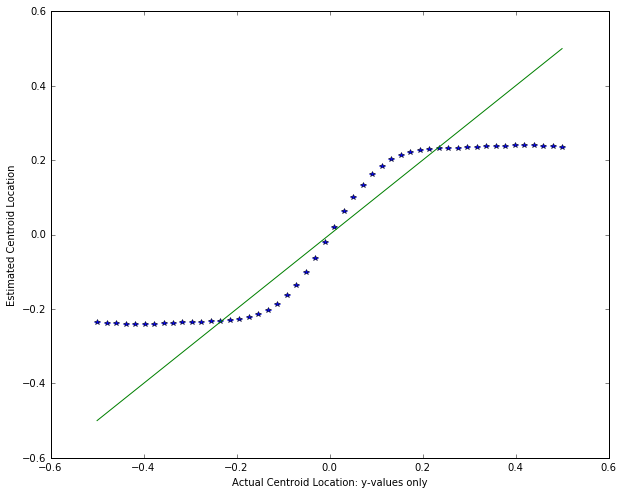

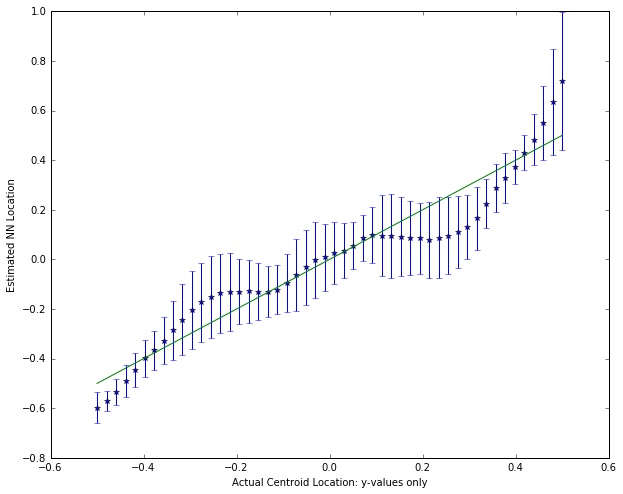

fullPixelLowNoise
0
1
2
3
4
5
6
Centroid L-2 Average Validation Error:  0.0150060303598
NN Average Validation Error:  0.0106820493013


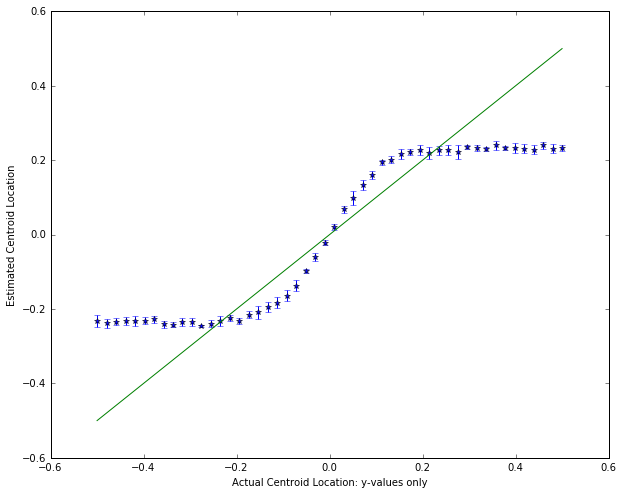

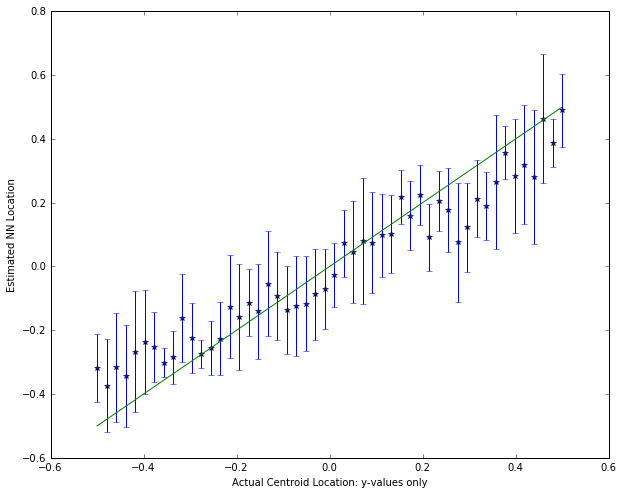

fullPixelMediumNoise
0
1
2
3
4
5
6
Centroid L-2 Average Validation Error:  0.0163503524527
NN Average Validation Error:  0.0167777072068


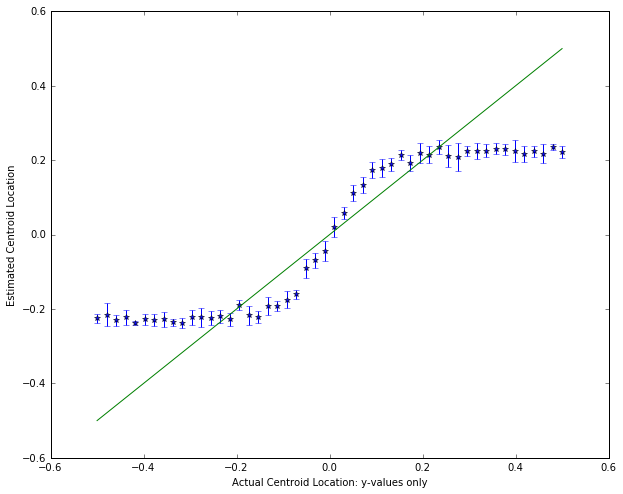

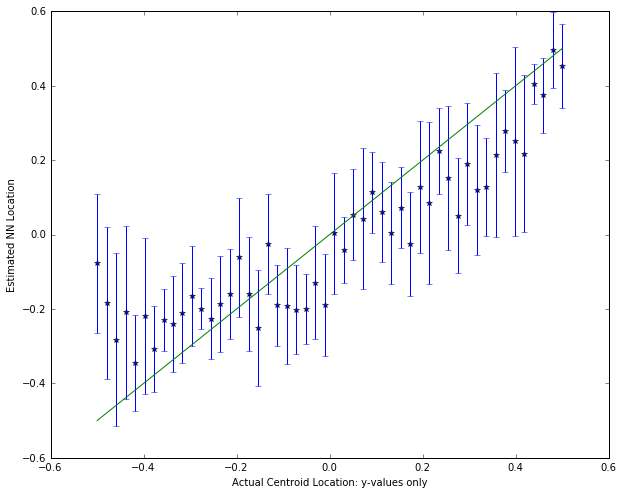

fullPixelHighNoise
0
1
2
3
4
5
6
Centroid L-2 Average Validation Error:  0.0189630545029
NN Average Validation Error:  0.0171343333055


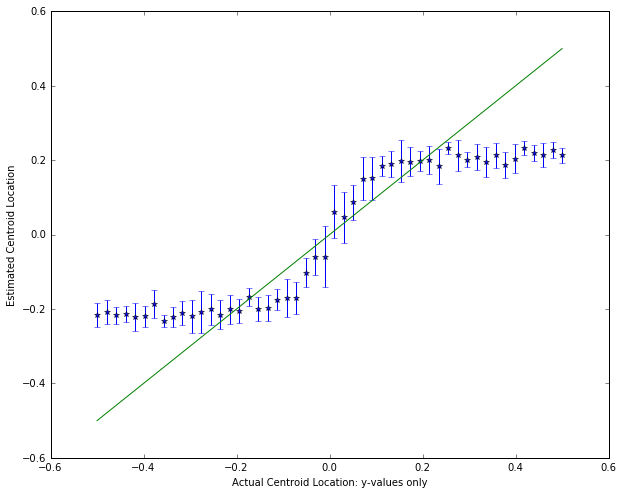

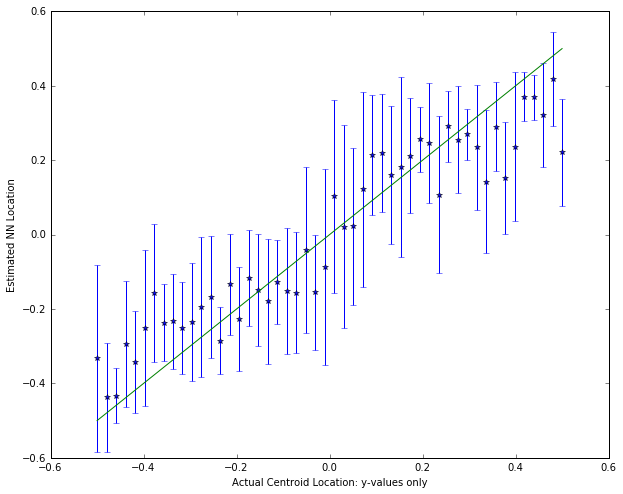

fullPixelNoNoise
0
1
2
3
4
5
6
Centroid L-2 Average Validation Error:  0.0150928358289
NN Average Validation Error:  0.000134400747213


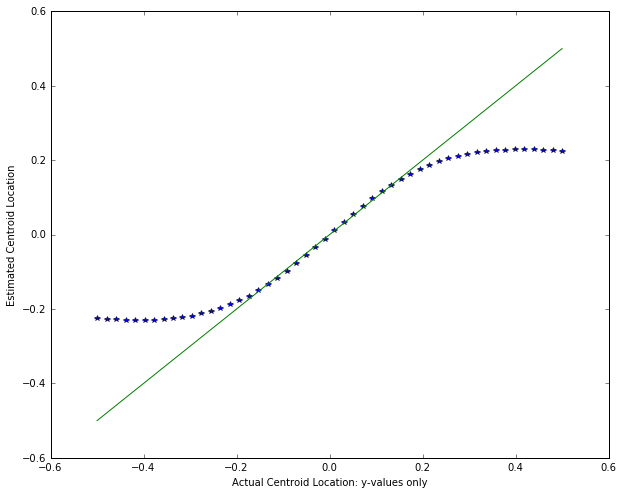

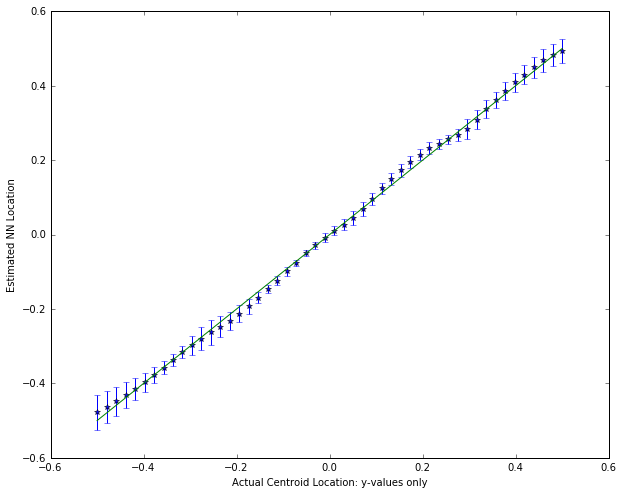

fullPixelLowNoise
0
1
2
3
4
5
6
Centroid L-2 Average Validation Error:  0.015634073564
NN Average Validation Error:  0.00194263257395


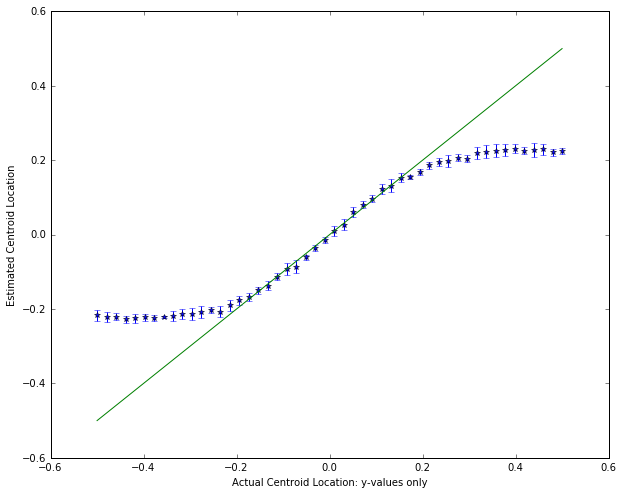

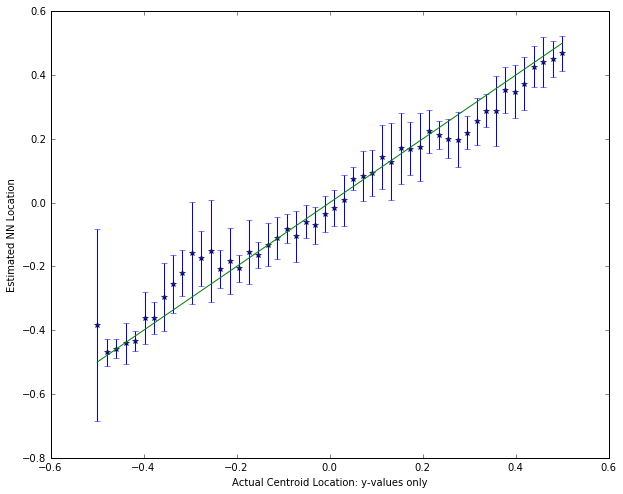

fullPixelMediumNoise
0
1
2
3
4
5
6
Centroid L-2 Average Validation Error:  0.017473028717
NN Average Validation Error:  0.00657617747568


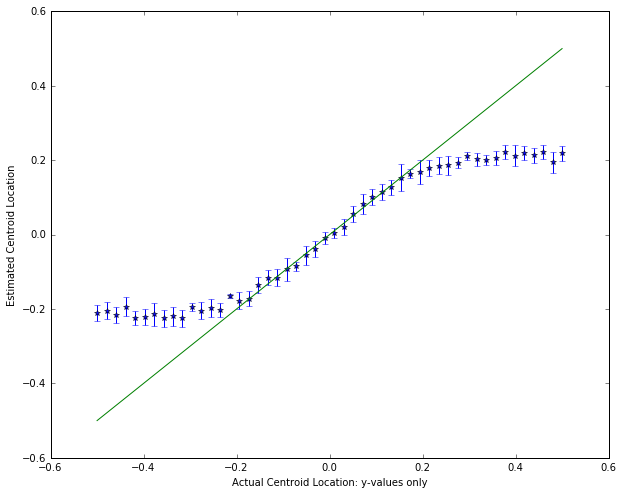

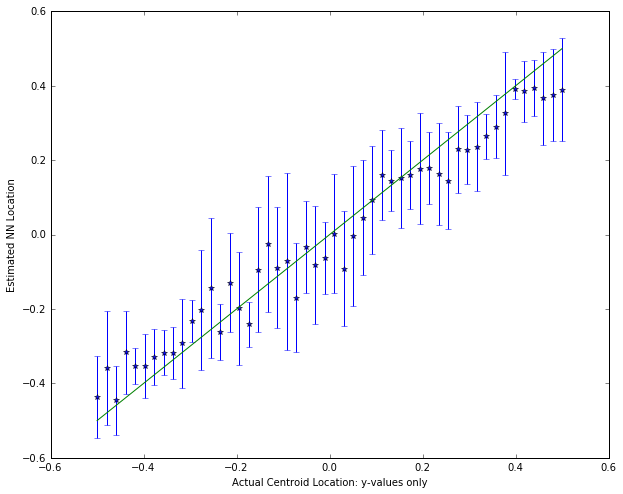

fullPixelHighNoise
0
1
2
3
4
5
6
Centroid L-2 Average Validation Error:  0.0188264724463
NN Average Validation Error:  0.010787375807


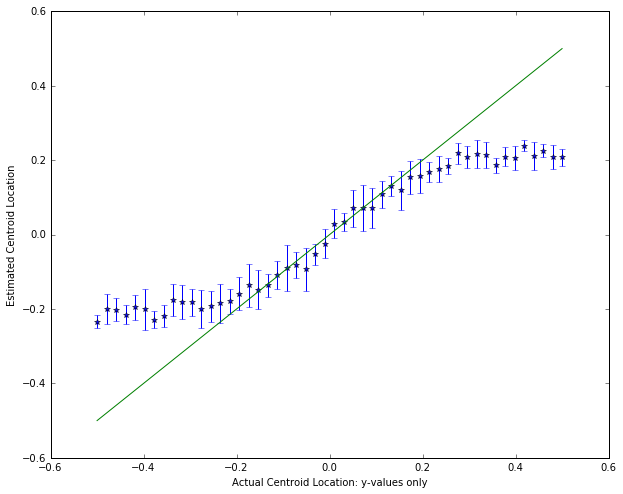

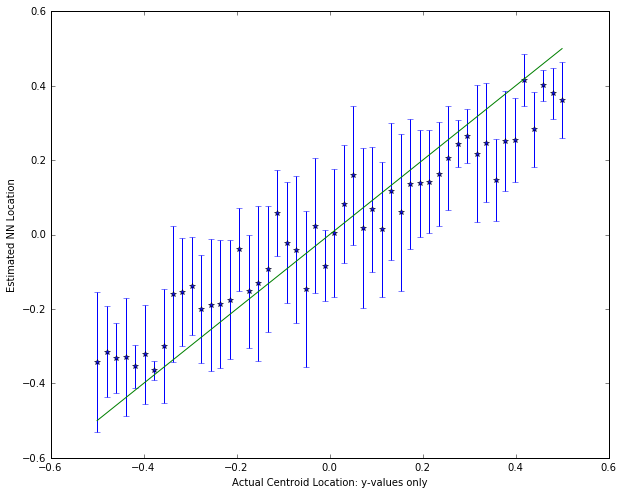

In [165]:
# Bucketing full pixel data
Training_Dict1 = {}
with open('cs231n/datasets/twohalfPixelNoNoiseData.txt', 'rb') as f1:
    data = np.load(f1)
    Training_Dict1['X'] = data['X']
    Training_Dict1['y'] = data['y']
    Training_Dict1['c'] = data['c']
    f1.close()
meansNoNoise, stdsNoNoise, centroid_errorNoNoise, NN_errorNoNoise = runDataMultipleSamples(Training_Dict1, fersnelNumber=4.0,numPoints = 50, iterations = 7, message='fullPixelNoNoise', hidden_dims=[75,75,75])
with open('cs231n/datasets/means_stds_3x75layer_50epochs_2x2_halfPixel_NoNoise.txt', 'w') as f1:
    np.savez(f1,means=meansNoNoise, stds = stdsNoNoise, centroid_error = centroid_errorNoNoise, NN_error = NN_errorNoNoise)
    f1.close()

Training_Dict2 = {}
with open('cs231n/datasets/twohalfPixelLowNoiseData.txt', 'rb') as f1:
    data = np.load(f1)
    Training_Dict2['X'] = data['X']
    Training_Dict2['y'] = data['y']
    Training_Dict2['c'] = data['c']
    f1.close()
meansLowNoise, stdsLowNoise, centroid_errorLowNoise, NN_errorLowNoise = runDataMultipleSamples(Training_Dict2, SNR=20,fersnelNumber=4.0, numPoints = 50, iterations = 7, message='fullPixelLowNoise', hidden_dims=[75,75,75])
with open('cs231n/datasets/means_stds_3x75layer_50epochs_2x2_halfPixel_LowNoise.txt', 'w') as f1:
    np.savez(f1,means=meansLowNoise, stds = stdsLowNoise, centroid_error = centroid_errorLowNoise, NN_error = NN_errorLowNoise)
    f1.close()

Training_Dict3 = {}
with open('cs231n/datasets/twohalfPixelMediumNoiseData.txt', 'rb') as f1:
    data = np.load(f1)
    Training_Dict3['X'] = data['X']
    Training_Dict3['y'] = data['y']
    Training_Dict3['c'] = data['c']
    f1.close()
meansMediumNoise, stdsMediumNoise, centroid_errorMediumNoise, NN_errorMediumNoise  =runDataMultipleSamples(Training_Dict3, SNR=10, fersnelNumber=4.0,numPoints = 50, iterations = 7,message='fullPixelMediumNoise', hidden_dims=[75,75,75])
with open('cs231n/datasets/means_stds_3x75layer_50epochs_2x2_halfPixel_MediumNoise.txt', 'w') as f1:
    np.savez(f1,means=meansMediumNoise, stds = stdsMediumNoise, centroid_error = centroid_errorMediumNoise, NN_error = NN_errorMediumNoise)
    f1.close()
    
Training_Dict4 = {}
with open('cs231n/datasets/twohalfPixelHighNoiseData.txt', 'rb') as f1:
    data = np.load(f1)
    Training_Dict4['X'] = data['X']
    Training_Dict4['y'] = data['y']
    Training_Dict4['c'] = data['c']
    f1.close()
meansHighNoise, stdsHighNoise, centroid_errorHighNoise, NN_errorHighNoise = runDataMultipleSamples(Training_Dict4, SNR=5, fersnelNumber=4.0,numPoints = 50, iterations = 7,message='fullPixelHighNoise', hidden_dims=[75,75,75])
with open('cs231n/datasets/means_stds_3x75layer_50epochs_2x2_halfPixel_HighNoise.txt', 'w') as f1:
    np.savez(f1,means=meansHighNoise, stds = stdsHighNoise, centroid_error = centroid_errorHighNoise, NN_error = NN_errorHighNoise)
    f1.close()
    
Training_Dict1 = {}
with open('cs231n/datasets/twofullPixelNoNoiseData.txt', 'rb') as f1:
    data = np.load(f1)
    Training_Dict1['X'] = data['X']
    Training_Dict1['y'] = data['y']
    Training_Dict1['c'] = data['c']
    f1.close()
meansNoNoise, stdsNoNoise, centroid_errorNoNoise, NN_errorNoNoise = runDataMultipleSamples(Training_Dict1, fersnelNumber=2.0,numPoints = 50, iterations = 7, message='fullPixelNoNoise', hidden_dims=[75,75,75])
with open('cs231n/datasets/means_stds_3x75layer_50epochs_2x2_fullPixel_NoNoise.txt', 'w') as f1:
    np.savez(f1,means=meansNoNoise, stds = stdsNoNoise, centroid_error = centroid_errorNoNoise, NN_error = NN_errorNoNoise)
    f1.close()

Training_Dict2 = {}
with open('cs231n/datasets/twofullPixelLowNoiseData.txt', 'rb') as f1:
    data = np.load(f1)
    Training_Dict2['X'] = data['X']
    Training_Dict2['y'] = data['y']
    Training_Dict2['c'] = data['c']
    f1.close()
meansLowNoise, stdsLowNoise, centroid_errorLowNoise, NN_errorLowNoise = runDataMultipleSamples(Training_Dict2, SNR=20,fersnelNumber=2.0, numPoints = 50, iterations = 7, message='fullPixelLowNoise', hidden_dims=[75,75,75])
with open('cs231n/datasets/means_stds_3x75layer_50epochs_2x2_fullPixel_LowNoise.txt', 'w') as f1:
    np.savez(f1,means=meansLowNoise, stds = stdsLowNoise, centroid_error = centroid_errorLowNoise, NN_error = NN_errorLowNoise)
    f1.close()

Training_Dict3 = {}
with open('cs231n/datasets/twofullPixelMediumNoiseData.txt', 'rb') as f1:
    data = np.load(f1)
    Training_Dict3['X'] = data['X']
    Training_Dict3['y'] = data['y']
    Training_Dict3['c'] = data['c']
    f1.close()
meansMediumNoise, stdsMediumNoise, centroid_errorMediumNoise, NN_errorMediumNoise  =runDataMultipleSamples(Training_Dict3, SNR=10, fersnelNumber=2.0,numPoints = 50, iterations = 7,message='fullPixelMediumNoise', hidden_dims=[75,75,75])
with open('cs231n/datasets/means_stds_3x75layer_50epochs_2x2_fullPixel_MediumNoise.txt', 'w') as f1:
    np.savez(f1,means=meansMediumNoise, stds = stdsMediumNoise, centroid_error = centroid_errorMediumNoise, NN_error = NN_errorMediumNoise)
    f1.close()
    
Training_Dict4 = {}
with open('cs231n/datasets/twofullPixelHighNoiseData.txt', 'rb') as f1:
    data = np.load(f1)
    Training_Dict4['X'] = data['X']
    Training_Dict4['y'] = data['y']
    Training_Dict4['c'] = data['c']
    f1.close()
meansHighNoise, stdsHighNoise, centroid_errorHighNoise, NN_errorHighNoise = runDataMultipleSamples(Training_Dict4, SNR=5, fersnelNumber=2.0,numPoints = 50, iterations = 7,message='fullPixelHighNoise', hidden_dims=[75,75,75])
with open('cs231n/datasets/means_stds_3x75layer_50epochs_2x2_fullPixel_HighNoise.txt', 'w') as f1:
    np.savez(f1,means=meansHighNoise, stds = stdsHighNoise, centroid_error = centroid_errorHighNoise, NN_error = NN_errorHighNoise)
    f1.close()

In [ ]:
Training_Dict5 = {}
with open('cs231n/datasets/fullPixelHighNoiseData.txt', 'rb') as f1:
    data = np.load(f1)
    Training_Dict5['X'] = data['X']
    Training_Dict5['y'] = data['y']
    Training_Dict5['c'] = data['c']
    f1.close()
differencesHighNoise = runDataMultipleSamples(Training_Dict5, SNR=5, numPoints = 1024, iterations = 7,message='fullPixelHighNoise', hidden_dims=[150,150,150])
    
Training_Dict6 = {}
with open('cs231n/datasets/fullPixelNoNoiseData.txt', 'rb') as f1:
    data = np.load(f1)
    Training_Dict6['X'] = data['X']
    Training_Dict6['y'] = data['y']
    Training_Dict6['c'] = data['c']
    f1.close()
differencesNoNoise = runDataMultipleSamples(Training_Dict6, numPoints = 1024, iterations = 7,message='fullPixelNoNoise', hidden_dims=[150,150,150])

with open('cs231n/datasets/differences.txt', 'w') as f1:
    np.savez(f1,differencesHighNoise=differencesHighNoise, differencesNoNoise = differencesNoNoise)
    f1.close()

In [164]:
def runDataMultipleSamples(Training_Dict, val=None, SNR=None, fersnelNumber=4.0, numPoints = 50, iterations = 7, message='', hidden_dims=[20]):
    print message
    tr = Training_Dict
    buckets = np.zeros((2,iterations,numPoints,2))
    means = np.zeros((2,numPoints,2))
    stds = np.zeros((2,numPoints,2))
    #val = generateValidationData(n=numPoints,SNR=SNR,fersnelNumber=fersnelNumber)
    for i in xrange(iterations):
        print i
        val = generateValidationData(n=numPoints,SNR=SNR,fersnelNumber=fersnelNumber)

        small = {
            'X_train': tr['X']/np.max(tr['X']),
            'y_train': tr['y'],
            'c_train': tr['c'],
            'X_val': val['X']/np.max(tr['X']),
            'y_val': val['y'],
            'c_val': val['c'],
        }

        input_dim=small['X_train'].shape[1]*small['X_train'].shape[2]
        weight_scale = 1e-2
        model = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.0001,num_classes=2, use_batchnorm=True)

        solver = Solver(model,small,
                        num_epochs=50, batch_size=64,
                        update_rule='adam',
                        optim_config={
                          'learning_rate': 1e-2,
                        },
                        verbose=False, print_every=100000,
                       lr_decay=.99)
        #solver.train()
        buckets[0,i,:,:] = solver.train()
        buckets[1,i,:,:] = val['c']
    means = np.mean(buckets,axis=1)
    stds = np.std(buckets,axis=1)  

    #val = generateValidationData(n=numPoints,SNR=SNR,fersnelNumber=fersnelNumber)    
    N = val['X'].shape[0]
    centroid_error = .5*np.sum((means[1,:,:]-val['y'])**2) / N
    NN_error = .5*np.sum((means[0,:,:]-val['y'])**2) / N
    print "Centroid L-2 Average Validation Error: ", centroid_error
    print "NN Average Validation Error: ", NN_error
    
    # Plot of Centroid Estimation values
    #x = np.linspace(-.5,.5,numPoints)
    x = means[1,:,0]
    y = means[1,:,1]
    e = stds[1,:,1]
    #plt.errorbar(x,y,e,linestyle='None',marker='*')
    plt.errorbar(np.linspace(-.5,.5,numPoints),y,e,linestyle='None',marker='*')
    plt.plot(np.linspace(-.5,.5,numPoints),np.linspace(-.5,.5,numPoints),'-')
    #plt.plot(np.linspace(0,.375,numPoints),np.linspace(.125,.5,numPoints),'+')
    plt.ylabel('Estimated Centroid Location')
    plt.xlabel('Actual Centroid Location: y-values only')
    plt.show()
    
    # Plot of Neural Network values
    #x = np.linspace(-.5,.5,numPoints)
    x = means[0,:,0]
    y = means[0,:,1]
    e = stds[0,:,1]
    #plt.errorbar(x,y,e,linestyle='None',marker='*')
    plt.errorbar(np.linspace(-.5,.5,numPoints),y,e,linestyle='None',marker='*')
    plt.plot(np.linspace(-.5,.5,numPoints),np.linspace(-.5,.5,numPoints),'-')
    #plt.plot(np.linspace(0,.375,numPoints),np.linspace(.125,.5,numPoints),'+')
    plt.ylabel('Estimated NN Location')
    plt.xlabel('Actual Centroid Location: y-values only')
    plt.show()
    return means, stds, centroid_error, NN_error
    
    # Color map for showing differences in errors
    #L2_NN_errors = np.sqrt(np.sum(((means[0,:,:]-val['y'])**2), axis=1))
    #L2_centroid_errors = np.sqrt(np.sum(((means[1,:,:]-val['y'])**2), axis=1))
    #differences = L2_centroid_errors - L2_NN_errors
    #differences = differences.reshape(np.sqrt(numPoints),np.sqrt(numPoints))
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    #p = ax.contourf(np.linspace(-.5,.5,num=32), np.linspace(-.5,.5,num=32), differences)
    #fig.colorbar(p)
    #return differences

In [ ]:
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(solver.loss_history, 'o', label='baseline')

plt.subplot(3, 1, 2)
plt.plot(solver.train_acc_history, '-o', label='baseline')

plt.subplot(3, 1, 3)
plt.plot(solver.val_acc_history, '-o', label='baseline')
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Centroids
fig,ax = plt.subplots()
ax.set_title('Conventional Centroid Estimator')
fig.suptitle('Case 1: Full Width, No Noise')
plt.ylabel('Estimated Centroid Location')
plt.xlabel('Actual Centroid Location')
plt.text(.3,-.3,'Fill this in')
values = solver.model.loss(small['X_val']) #X[start:end]
ax.plot(val['y'][:,0],val['y'][:,1],'-',np.linspace(-.5,.5,50),val['c'][:,1],'*', np.linspace(-.5,.5,50),values[:,1],'+')
ax.locator_params(tight=True)
plt.show()

# Neural Network
#fig,ax = plt.subplots()
#ax.set_title('Neural Network')
#fig.suptitle('Case 1: Full Width, No Noise')
#plt.ylabel('Estimated Centroid Location')
#plt.xlabel('Actual Centroid Location')
#plt.text(.3,-.3,'Fill this in')
#values = solver.model.loss(small['X_val'])
#ax.plot(val['y'][:,0],val['y'][:,1],'-',np.linspace(-.5,.5,50),values[:,1],'*')
#ax.locator_params(tight=True)
#plt.show()

In [ ]:
#data_train = generateData(100000)
#print "training data done"
#data_val = generateData(4096)

N = data_val['X'].shape[0]
print "Centroid L-2 Average Loss: ", .5*np.sum((data_val['c']-data_val['y'])**2) / N


#small_data = {
#  'X_train': data_train['X']*1e7,
#  'y_train': data_train['y'],
#  'X_val': data_val['X']*1e7,
#  'y_val': data_val['y'],
#}

input_dim=data_train['X'].shape[1]*data_train['X'].shape[2]
weight_scale = 1e-2

print "[20]"
hidden_dims = [20]
model20 = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver20 = Solver(model20, small_data,
                num_epochs=150, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.92)
solver20.train()
print "Final training loss: ", solver20.loss_history[-1]
print "Final training acc: ", solver20.train_acc_history[-1]
print "Final validation error: ", solver20.val_acc_history[-1]

print "[50,50,50]"
hidden_dims = [50,50,50]
model505050 = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver505050 = Solver(model505050, small_data,
                num_epochs=150, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.92)
solver505050.train()
print "Final training loss: ", solver505050.loss_history[-1]
print "Final training acc: ", solver505050.train_acc_history[-1]
print "Final validation error: ", solver505050.val_acc_history[-1]

print "[70,70,70]"
hidden_dims = [70,70,70]
model707070 = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver707070 = Solver(model707070, small_data,
                num_epochs=150, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.92)
solver707070.train()
print "Final training loss: ", solver707070.loss_history[-1]
print "Final training acc: ", solver707070.train_acc_history[-1]
print "Final validation error: ", solver707070.val_acc_history[-1]

print "[120,120,120]"
hidden_dims = [120,120,120]
model120120120 = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver120120120 = Solver(model120120120, small_data,
                num_epochs=150, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.92)
solver120120120.train()
print "Final training loss: ", solver120120120.loss_history[-1]
print "Final training acc: ", solver120120120.train_acc_history[-1]
print "Final validation error: ", solver120120120.val_acc_history[-1]

print "[50,50,50,50]"
hidden_dims = [50,50,50,50]
model50505050 = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver50505050 = Solver(model50505050, small_data,
                num_epochs=150, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.92)
solver50505050.train()
print "Final training loss: ", solver50505050.loss_history[-1]
print "Final training acc: ", solver50505050.train_acc_history[-1]
print "Final validation error: ", solver50505050.val_acc_history[-1]

print "[70,70,70,70]"
hidden_dims = [70,70,70,70]
model70707070 = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver70707070 = Solver(model70707070, small_data,
                num_epochs=150, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.92)
solver70707070.train()
print "Final training loss: ", solver70707070.loss_history[-1]
print "Final training acc: ", solver70707070.train_acc_history[-1]
print "Final validation error: ", solver70707070.val_acc_history[-1]

print "[120,120,120,120]"
hidden_dims = [120,120,120,120]
model120120120120 = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver120120120120 = Solver(model120120120120, small_data,
                num_epochs=150, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.92)
solver120120120120.train()
print "Final training loss: ", solver120120120120.loss_history[-1]
print "Final training acc: ", solver120120120120.train_acc_history[-1]
print "Final validation error: ", solver120120120120.val_acc_history[-1]

print "[70,70,70,70].90"
hidden_dims = [70,70,70,70]
model47095 = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver47095 = Solver(model47095, small_data,
                num_epochs=150, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.90)
solver47095.train()
print "Final training loss: ", solver47095.loss_history[-1]
print "Final training acc: ", solver47095.train_acc_history[-1]
print "Final validation error: ", solver47095.val_acc_history[-1]

print "[70,70,70,70].95"
hidden_dims = [70,70,70,70]
model47099 = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver47099 = Solver(model47099, small_data,
                num_epochs=150, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.95)
solver47099.train()
print "Final training loss: ", solver47099.loss_history[-1]
print "Final training acc: ", solver47099.train_acc_history[-1]
print "Final validation error: ", solver47099.val_acc_history[-1]

#######################
#pixelSize      = .5*1e-3; # meters
#data_train8 = generateData(100000)
#print "training data done"
#data_val8 = generateData(4096)

N = data_val8['X'].shape[0]
print "Centroid L-2 Average Loss: ", .5*np.sum((data_val8['c']-data_val8['y'])**2) / N


#small_data8 = {
#  'X_train': data_train8['X']*1e7,
#  'y_train': data_train8['y'],
#  'X_val': data_val8['X']*1e7,
#  'y_val': data_val8['y'],
#}

input_dim=data_train8['X'].shape[1]*data_train8['X'].shape[2]
weight_scale = 1e-2

print "[20]"
hidden_dims = [20]
model208 = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver208 = Solver(model208, small_data8,
                num_epochs=150, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.92)
solver208.train()
print "Final training loss: ", solver208.loss_history[-1]
print "Final training acc: ", solver208.train_acc_history[-1]
print "Final validation error: ", solver208.val_acc_history[-1]

print "[50,50,50]"
hidden_dims = [50,50,50]
model5050508 = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver5050508 = Solver(model5050508, small_data8,
                num_epochs=150, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.92)
solver5050508.train()
print "Final training loss: ", solver5050508.loss_history[-1]
print "Final training acc: ", solver5050508.train_acc_history[-1]
print "Final validation error: ", solver5050508.val_acc_history[-1]

print "[70,70,70]"
hidden_dims = [70,70,70]
model7070708 = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver7070708 = Solver(model7070708, small_data8,
                num_epochs=150, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.92)
solver7070708.train()
print "Final training loss: ", solver7070708.loss_history[-1]
print "Final training acc: ", solver7070708.train_acc_history[-1]
print "Final validation error: ", solver7070708.val_acc_history[-1]

print "[120,120,120]"
hidden_dims = [120,120,120]
model1201201208 = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver1201201208 = Solver(model1201201208, small_data8,
                num_epochs=150, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.92)
solver1201201208.train()
print "Final training loss: ", solver1201201208.loss_history[-1]
print "Final training acc: ", solver1201201208.train_acc_history[-1]
print "Final validation error: ", solver1201201208.val_acc_history[-1]

print "[50,50,50,50]"
hidden_dims = [50,50,50,50]
model505050508 = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver505050508 = Solver(model505050508, small_data8,
                num_epochs=150, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.92)
solver505050508.train()
print "Final training loss: ", solver505050508.loss_history[-1]
print "Final training acc: ", solver505050508.train_acc_history[-1]
print "Final validation error: ", solver505050508.val_acc_history[-1]

print "[70,70,70,70]"
hidden_dims = [70,70,70,70]
model707070708 = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver707070708 = Solver(model707070708, small_data8,
                num_epochs=150, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.92)
solver707070708.train()
print "Final training loss: ", solver707070708.loss_history[-1]
print "Final training acc: ", solver707070708.train_acc_history[-1]
print "Final validation error: ", solver707070708.val_acc_history[-1]

print "[120,120,120,120]"
hidden_dims = [120,120,120,120]
model1201201201208 = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver1201201201208 = Solver(model1201201201208, small_data8,
                num_epochs=150, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.92)
solver1201201201208.train()
print "Final training loss: ", solver1201201201208.loss_history[-1]
print "Final training acc: ", solver1201201201208.train_acc_history[-1]
print "Final validation error: ", solver1201201201208.val_acc_history[-1]

print "[70,70,70,70].95"
hidden_dims = [70,70,70,70]
model470958 = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver470958 = Solver(model470958, small_data8,
                num_epochs=150, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.95)
solver470958.train()
print "Final training loss: ", solver470958.loss_history[-1]
print "Final training acc: ", solver470958.train_acc_history[-1]
print "Final validation error: ", solver470958.val_acc_history[-1]

print "[70,70,70,70].90"
hidden_dims = [70,70,70,70]
model470998 = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver470998 = Solver(model470998, small_data8,
                num_epochs=150, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.90)
solver470998.train()
print "Final training loss: ", solver470998.loss_history[-1]
print "Final training acc: ", solver470998.train_acc_history[-1]
print "Final validation error: ", solver470998.val_acc_history[-1]

In [ ]:
def fiftyByFiftyApertureData(n=50):
    data = {}
    data['X'] = np.zeros((n,n,numberOfPixels,numberOfPixels))
    data['y'] = np.zeros((n,n,2))
    
    for i in xrange(n*n):
        # Could also make y-values the xTilt and yTilt
        xTilt = -.5*np.random.uniform(-1.0,1.0)#np.sin(theta)*np.cos(phi)
        yTilt = -.5*np.random.uniform(-1.0,1.0)#np.sin(theta)*np.sin(phi)
        data['y'][i,0] = -ratio2*xTilt
        data['y'][i,1] = -ratio2*yTilt
        pixelPointsXMesh, pixelPointsYMesh = np.meshgrid(pixelPoints,pixelPoints)
        scatterPixelPointsX = np.reshape(pixelPointsXMesh,(1,np.size(pixelPointsXMesh)))
        scatterPixelPointsY = np.reshape(pixelPointsYMesh,(1,np.size(pixelPointsYMesh)))
        Fx = np.sinc(fersnelNumber*(focalPlaneMeshX + ratio2*xTilt))
        #plt.plot(spaceDimensionPoints,Fx**2.0)
        Fy = np.sinc(fersnelNumber*(focalPlaneMeshY + ratio2*yTilt))
        irradiance = vacuumPermittivity*speedOfLight*(amplitudeOfLight**2.0) * (Fx**2.0) * (Fy**2.0)
        pixelBlocks = np.zeros((numberOfPixels,numberOfPixels,pointsPerPixel,pointsPerPixel))

        meshXBlocks = np.zeros((numberOfPixels,numberOfPixels,pointsPerPixel,pointsPerPixel))
        meshYBlocks = np.zeros((numberOfPixels,numberOfPixels,pointsPerPixel,pointsPerPixel))
        integrals    = np.zeros([numberOfPixels,numberOfPixels])

        for indexPixel1 in range(0,numberOfPixels):
            for indexPixel2 in range(0,numberOfPixels):
                for indexPoint1 in range(0,pointsPerPixel):
                    for indexPoint2 in range(0,pointsPerPixel):
                        pixelBlocks[indexPixel1,indexPixel2,indexPoint1,indexPoint2] = irradiance[indexPixel1*(pointsPerPixel-1) + indexPoint1
                                                                                                ,indexPixel2*(pointsPerPixel-1) + indexPoint2]
                        meshXBlocks[indexPixel1,indexPixel2,indexPoint1,indexPoint2] = focalPlaneMeshX[indexPixel1*(pointsPerPixel-1) + indexPoint1
                                                                                                ,indexPixel2*(pointsPerPixel-1) + indexPoint2]
                        meshYBlocks[indexPixel1,indexPixel2,indexPoint1,indexPoint2] = focalPlaneMeshY[indexPixel1*(pointsPerPixel-1) + indexPoint1
                                                                                                ,indexPixel2*(pointsPerPixel-1) + indexPoint2]
        
                        x = meshXBlocks[indexPixel1,indexPixel2,0,:]
                        y = meshYBlocks[indexPixel1,indexPixel2,:,0]
        
                        integrals[indexPixel1,indexPixel2] = simps(simps(pixelBlocks[indexPixel1,indexPixel2,:,:], y), x)
                        # ADD Low NOISE
                        #integrals[indexPixel1,indexPixel2] += 1e-6*np.random.normal()*1/10
                        # ADD High NOISE
                        #integrals[indexPixel1,indexPixel2] += 1e-6*np.random.normal()*1/4
        # Find centers of each cell and overall centroid
        centerX, centerY = np.meshgrid(centerPoints,centerPoints)     
        data['X'][i,:] = integrals
        centerX = np.reshape(centerX,(1,np.size(centerX)))
        centerY = np.reshape(centerY,(1,np.size(centerY)))
        integrals = np.reshape(integrals,(1,np.size(integrals)))
        meanX = np.sum(centerX*integrals)/np.sum(integrals)
        meanY = np.sum(centerY*integrals)/np.sum(integrals)
        centroid = [meanX, meanY]
        centers = np.hstack((centerX.T,centerY.T))
        data['c'][i,0] = meanX
        data['c'][i,1] = meanY

In [ ]:
def sequenceApertureData(size = 50, sequenceLength = 100, numSequences=1000)
    ddata['X'] = np.zeros((n,numberOfPixels,numberOfPixels))
    data['y'] = np.zeros((n,2))ata = {}
    

In [ ]:
# Normalizes Training Nx2d data
def normalizeData(x)
    data = x.copy()
    mu = np.mean(data, axis=0)
    var = np.var(data, axis = 0)
    data /= np.max(np.abs(data)) # helps cases when 1e-5 is larger than data
    data = (data - mu) / np.sqrt(var + 1e-5)
    return data

In [ ]:
normalized_data = small_data.copy()
mu = np.mean(normalized_data['X_train'], axis=0)
var = np.var(normalized_data['X_train'], axis = 0)
normalized_data['X_train'] = (normalized_data['X_train'] - mu) / np.sqrt(var + 1e-5)
mu = np.mean(normalized_data['X_val'], axis=0)
var = np.var(normalized_data['X_val'], axis = 0)
normalized_data['X_val'] = (normalized_data['X_val'] - mu) / np.sqrt(var + 1e-5)

N = data_val['X'].shape[0]
print "Centroid L-2 Average Loss: ", .5*np.sum((data_val['c']-data_val['y'])**2) / N


input_dim=data_train['X'].shape[1]*data_train['X'].shape[2]
weight_scale = 1e-3

print "[70,70,70,70]"
hidden_dims = [300,300,300,300]
#model = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver = Solver(model, normalized_data,
                num_epochs=300, batch_size=512,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-6,
                },
                verbose=True, print_every=1000,
               lr_decay=1)
solver.train()
print "Final training loss: ", solver.loss_history[-1]
print "Final training acc: ", solver.train_acc_history[-1]
print "Final validation error: ", solver.val_acc_history[-1]

In [ ]:
print small_data['X_train'][18000,:,:]

In [ ]:
#np.fliplr(tep.T).T

In [ ]:
data_train = generateData(7500)
print "training data done"
data_val = generateData(512)

In [ ]:
#print data_train['X'].shape
#print data_val['X'].shape

In [ ]:
#print "X.shape :", data_val['X'][2,:].shape
print "Tilts :", data_val['y'][5,:]
print "Centroids :", data_val['c'][5,:]
print "L-2 Sample Loss: ", np.sqrt(np.sum((data_val['c'][5,:]-data_val['y'][5,:])**2))
N = data_val['X'].shape[0]
print N
print "L-2 Average Loss: ", .5*np.sum((data_val['c']-data_val['y'])**2) / N

In [ ]:
# Peprocessing
# Center data
#mean_image = np.mean(data_train['X'], axis=0)
#data_train['X'] -= mean_image
#data_val['X'] -= mean_image
#X_test -= mean_image

In [ ]:
# Try training a very deep net with batchnorm
hidden_dims = [70,70,70,70]

small_data = {
  'X_train': data_train['X']*1e7,
  'y_train': data_train['y'],
  'X_val': data_val['X']*1e7,
  'y_val': data_val['y'],
}

input_dim=data_train['X'].shape[1]*data_train['X'].shape[2]
weight_scale = 1e-2
model = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)

solver = Solver(model, small_data,
                num_epochs=200, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.99)
solver.train()

In [ ]:
print "Final training loss: ", solver.loss_history[-1]
print "Final training acc: ", solver.train_acc_history[-1]
print "Final validation error: ", solver.val_acc_history[-1]

In [ ]:
# Try training a very deep net with batchnorm
print "[70,70,70]"
hidden_dims = [70,70,70]
small_data = {
  'X_train': data_train['X'],
  'y_train': data_train['y'],
  'X_val': data_val['X'],
  'y_val': data_val['y'],
}
model = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver = Solver(model, small_data,
                num_epochs=300, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.95)
solver.train()
print "Final training loss: ", solver.loss_history[-1]
print "Final training acc: ", solver.train_acc_history[-1]
print "Final validation error: ", solver.val_acc_history[-1]

print "[100,100,100]"
hidden_dims = [100,100,100]
model = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver = Solver(model, small_data,
                num_epochs=300, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.95)
solver.train()
print "Final training loss: ", solver.loss_history[-1]
print "Final training acc: ", solver.train_acc_history[-1]
print "Final validation error: ", solver.val_acc_history[-1]

print "[40,40,40,40]"
hidden_dims = [40,40,40,40]
model = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver = Solver(model, small_data,
                num_epochs=300, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.95)
solver.train()
print "Final training loss: ", solver.loss_history[-1]
print "Final training acc: ", solver.train_acc_history[-1]
print "Final validation error: ", solver.val_acc_history[-1]

print "[40,40,40,40]"
hidden_dims = [50,50,50,50]
model = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver = Solver(model, small_data,
                num_epochs=100, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.95)
solver.train()
print "Final training loss: ", solver.loss_history[-1]
print "Final training acc: ", solver.train_acc_history[-1]
print "Final validation error: ", solver.val_acc_history[-1]

print "[70,70,70,70]"
hidden_dims = [70,70,70,70]
model = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver = Solver(model, small_data,
                num_epochs=300, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.95)
solver.train()
print "Final training loss: ", solver.loss_history[-1]
print "Final training acc: ", solver.train_acc_history[-1]
print "Final validation error: ", solver.val_acc_history[-1]

print "[70,70,70,70]*1000"
hidden_dims = [70,70,70,70]
model = FullyConnectedNet(hidden_dims, input_dim=input_dim, weight_scale=weight_scale, reg=.00001,num_classes=2, use_batchnorm=True)
solver = Solver(model, small_data,
                num_epochs=1000, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.95)
solver.train()
print "Final training loss: ", solver.loss_history[-1]
print "Final training acc: ", solver.train_acc_history[-1]
print "Final validation error: ", solver.val_acc_history[-1]


In [ ]:
solver = Solver(model, small_data,
                num_epochs=5, batch_size=32,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=False, print_every=200,
               lr_decay=.95)
solver.train()
solver.train()
print "Final training loss: ", solver.loss_history[-1]
print "Final training acc: ", solver.train_acc_history[-1]
print "Final validation error: ", solver.val_acc_history[-1]

In [ ]:
print small_data['X_train'][0,:,:]

In [ ]:
scores = solver.model.loss(data_val['X'][100,:,:])

In [ ]:
print "Final training loss: ", solver.loss_history[-1]
print "Final training acc: ", solver.train_acc_history[-1]
print "Final validation error: ", solver.val_acc_history[-1]

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(solver.loss_history, 'o', label='baseline')

plt.subplot(3, 1, 2)
plt.plot(solver.train_acc_history, '-o', label='baseline')

plt.subplot(3, 1, 3)
plt.plot(solver.val_acc_history, '-o', label='baseline')
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

In [ ]:
### STOP HERE ###

In [ ]:
print 'X: ', np.max(data_val['X']), np.min(data_val['X']), np.mean(data_val['X'])
print 'y: ', np.max(data_val['y']), np.min(data_val['y']), np.mean(data_val['y']), np.sum(data_val['y'])
print 'c: ', np.max(data_val['c']), np.min(data_val['c']), np.mean(data_val['c']), np.sum(data_val['c'])
centroid_error = .5*np.sum((data_val['c']-data_val['y'])**2) / data_val['y'].shape[0]/np.abs(np.max(data_val['y']))
print "centroid_error: ", centroid_error
zero_error = .5*np.sum((0-data_val['y'])**2) / data_val['y'].shape[0]/np.max(data_val['y'])
print "zero_error: ", zero_error
scores = solver.model.loss(data_val['X'])
np.sum(np.sign(scores))
print "Sign diff scores,c: ", np.sum(np.sign(scores)-np.sign(data_val['c']))
print "Sign diff scores,-y: ", np.sum(np.sign(scores)+np.sign(data_val['y']))
print "Sign diff c,-y: ", np.sum(np.sign(data_val['c'])+np.sign(data_val['y']))
print "Sum scores: ", np.sum(scores)
print "Abs diff scores,c: ",np.sum(np.abs(scores-data_val['y']))
#print "check_accuracy: ", solver.check_accuracy(data_val['X'], data_val['c'])
#print "val_acc_history: ", solver.val_acc_history

In [ ]:
best_train_accs = []
best_val_accs  = []
final_train_loss = []
for ws in regs:

  best_train_accs.append(max(solvers[ws].train_acc_history))
  
  best_val_accs.append(max(solvers[ws].val_acc_history))
  
  final_train_loss.append(np.mean(solvers[ws].loss_history[-100:]))
  
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(regs, best_val_accs, '-o', label='baseline')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(regs, best_train_accs, '-o', label='baseline')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(regs, final_train_loss, '-o', label='baseline')
plt.legend()

plt.gcf().set_size_inches(10, 15)
plt.show()

In [ ]:
rng = np.random.RandomState(1)
X=data_train['X'].copy()
y_tr=data_train['y'].copy()
regr_1 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)
#regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
#                          n_estimators=300, random_state=rng)
Xtr = X.copy()
Xtr = Xtr.reshape((256,32*32))
regr_1.fit(Xtr, y_tr)
#regr_1.fit(Xtr, y_tr[:,0])
#regr_2.fit(Xtr, y_tr[:,1])

# Predict
X2=data_val['X'].copy()
y=data_val['y'].copy()
X2 = X2.reshape((32,32*32))
y_1 = regr_1.predict(X2)
#y_1 = regr_1.predict(X2)
#y_2 = regr_2.predict(X2)

print "Loss: ", .5*np.sum((y_1-y)**2)/ 32
#print np.sum((np.sign(y_1)!=np.sign(y[:,0])))+np.sum(np.sign(y_2)!=np.sign(y[:,1]))
#print "Loss: ", .5*np.sum((y_1-y[:,0])**2+(y_2-y[:,1])**2) / 32 /np.max(np.max(y[:,0]),np.max(y[:,1]))
#print "Loss2: ", np.sum(np.abs(y_1-y[:,0])+np.abs(y_2-y[:,1]))
# Plot the results
plt.figure()
plt.scatter(np.linspace(0,1,32), .5*np.sum(y_1-y**2)/32, c="k", label="training samples")
plt.plot(np.linspace(0,1,32), y_1, c="g", label="n_estimators=1", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend()
plt.show()
#plt.figure()
#plt.scatter(np.linspace(0,1,32), .5*np.sum((y_2-y[:,1])**2), c="k", label="training samples")
#plt.plot(np.linspace(0,1,32), y_2, c="g", label="n_estimators=1", linewidth=2)
#plt.xlabel("data")
#plt.ylabel("target")
#plt.title("Boosted Decision Tree Regression")
#plt.legend()
#plt.show()


In [ ]:
#### END ####

In [ ]:
pixelPointsXMesh, pixelPointsYMesh = np.meshgrid(pixelPoints,pixelPoints)

In [ ]:
scatterPixelPointsX = np.reshape(pixelPointsXMesh,(1,np.size(pixelPointsXMesh)))
scatterPixelPointsY = np.reshape(pixelPointsYMesh,(1,np.size(pixelPointsYMesh)))

In [ ]:
Fx = np.sinc(fersnelNumber*(focalPlaneMeshX + ratio2*xTilt))
#plt.plot(spaceDimensionPoints,Fx**2.0)
Fy = np.sinc(fersnelNumber*(focalPlaneMeshY + ratio2*yTilt))

In [ ]:
irradiance = vacuumPermittivity*speedOfLight*(amplitudeOfLight**2.0) * (Fx**2.0) * (Fy**2.0)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
lensPoints = np.array([[-1.0,-1.0],[-1.0,1.0], [1.0,1.0],[1.0,-1.0],[-1.0,-1.0]])
lensPoints[0,0]
p = ax.contourf(focalPlaneMeshX, focalPlaneMeshY, irradiance,100)
ax.scatter(scatterPixelPointsX,scatterPixelPointsY,color='red')

fig.colorbar(p)

In [ ]:
pixelBlocks = np.zeros((numberOfPixels,numberOfPixels,pointsPerPixel,pointsPerPixel))
meshXBlocks = np.zeros((numberOfPixels,numberOfPixels,pointsPerPixel,pointsPerPixel))
meshYBlocks = np.zeros((numberOfPixels,numberOfPixels,pointsPerPixel,pointsPerPixel))
integrals    = np.zeros([numberOfPixels,numberOfPixels])

for indexPixel1 in range(0,numberOfPixels):
    for indexPixel2 in range(0,numberOfPixels):
        for indexPoint1 in range(0,pointsPerPixel):
            for indexPoint2 in range(0,pointsPerPixel):
                pixelBlocks[indexPixel1,indexPixel2,indexPoint1,indexPoint2] = irradiance[indexPixel1*(pointsPerPixel-1) + indexPoint1
                                                                                        ,indexPixel2*(pointsPerPixel-1) + indexPoint2]
                meshXBlocks[indexPixel1,indexPixel2,indexPoint1,indexPoint2] = focalPlaneMeshX[indexPixel1*(pointsPerPixel-1) + indexPoint1
                                                                                        ,indexPixel2*(pointsPerPixel-1) + indexPoint2]
                meshYBlocks[indexPixel1,indexPixel2,indexPoint1,indexPoint2] = focalPlaneMeshY[indexPixel1*(pointsPerPixel-1) + indexPoint1
                                                                                        ,indexPixel2*(pointsPerPixel-1) + indexPoint2]
                
                x = meshXBlocks[indexPixel1,indexPixel2,0,:]
                y = meshYBlocks[indexPixel1,indexPixel2,:,0]

                integrals[indexPixel1,indexPixel2] = simps(simps(pixelBlocks[indexPixel1,indexPixel2,:,:], y), x)

In [ ]:
integrals[1,1]


In [ ]:
(integrals/joulesPerPhoton)*pulseDuration + 5*np.random.randn(integrals.shape[0],integrals.shape[1])

In [ ]:
centerX, centerY = np.meshgrid(centerPoints,centerPoints)
centerX = np.reshape(centerX,(1,np.size(centerX)))
centerY = np.reshape(centerY,(1,np.size(centerY)))
integrals = np.reshape(integrals,(1,np.size(integrals)))
meanX = np.mean(centerX*integrals)
meanY = np.mean(centerY*integrals)
centroid = [meanX, meanY]    
centers = np.hstack((centerX.T,centerY.T))
#Alternative calculation: centroid=np.mean(centers*np.reshape(integrals,(np.size(integrals),1)), axis=0)
print centroid
print centers

In [ ]:
xvector

In [ ]:
fig = plt.figure(figsize=(14,6))

# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(1, 2, 1, projection='3d')

p = ax.plot_surface(integrals)


In [ ]:
plt.contourf(meshXBlocks[0,0,:,:],meshYBlocks[0,0,:,:], pixelBlocks[0,0,:,:],100)


In [ ]:
plt.contourf(meshXBlocks[0,0,:,:],meshYBlocks[0,0,:,:], pixelBlocks[0,0,:,:])

[meshXBlocks[0,0,0,pointsPerPixel-1],meshYBlocks[0,0,0,pointsPerPixel-1],pixelBlocks[0,0,0,pointsPerPixel-1]]
        

In [ ]:


meshXBlocks[0,0,0,:]
        

In [ ]:
[meshXBlocks[1,0,:,:],
meshYBlocks[1,0,:,:],pixelBlocks[1,0,:,:]]

In [ ]:
fig = plt.figure()
for indexPixel1 in range(0,10):
    for indexPixel2 in range(0,10):
        ax = fig.add_subplot(10,10, indexPixel1*(10-1)+indexPixel2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.contourf(meshXBlocks[indexPixel1,indexPixel2,:,:],meshYBlocks[indexPixel1,indexPixel2,:,:], pixelBlocks[indexPixel1,indexPixel2,:,:],100)

In [ ]:
fig = plt.figure(figsize=(14,6))

# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(1, 2, 1, projection='3d')

p = ax.plot_surface(apertureDiameter*xv, apertureDiameter*yv, irradiance, rstride=16, cstride=16)


In [ ]:
fftF = (1.0/numberOfPointsSpaceDimension) * np.fft.fftshift(np.fft.fft(F))
wxv, wyv = np.meshgrid(waveNumberDimensionPoints, waveNumberDimensionPoints)

In [ ]:
fig = plt.figure(figsize=(14,6))

# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(1, 2, 1, projection='3d')

p = ax.plot_surface(wxv, wyv, np.abs(fftF)**2.0, rstride=1, cstride=1, linewidth=0)